In [ ]:
import scanpy as sc
import seaborn as sns
import numpy as np
import pandas as pd
import random
import os
from matplotlib.pyplot import rc_context
sc.set_figure_params(dpi=100)

import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)
# Set working directory
os.chdir("P:/Tolulope/Cellranger Results/YNO")
adata = sc.read_h5ad('integrated OLD.h5ad')
adata

In [ ]:
# Subset for endothelial cells
cell_subset = adata[adata.obs['cell type'] == "Lipid-Laden Macrophages"].copy()  # Make sure to use .copy() to avoid modifying original object
from scipy.sparse import csr_matrix
# Convert to sparse matrix
cell_subset.X = csr_matrix(cell_subset.X)

In [3]:
cell_subset.X

<4186x22591 sparse matrix of type '<class 'numpy.float32'>'
	with 94565926 stored elements in Compressed Sparse Row format>

In [1]:
#example WITH pseudo replicates
pbs = []
for sample in cell_subset.obs.Sample.unique():
    samp_cell_subset = cell_subset[cell_subset.obs['Sample'] == sample]
    
    samp_cell_subset.X = samp_cell_subset.layers['counts'] #make sure to use raw data
    
    
    
    indices = list(samp_cell_subset.obs_names)
    random.shuffle(indices)
    indices = np.array_split(np.array(indices), 4) #change number here for number of replicates deisred
    
    for i, pseudo_rep in enumerate(indices):
    
        rep_adata = sc.AnnData(X = samp_cell_subset[indices[i]].X.sum(axis = 0),
                               var = samp_cell_subset[indices[i]].var[[]])

        rep_adata.obs_names = [sample + '_' + str(i)]
        rep_adata.obs['condition'] = samp_cell_subset.obs['condition'].iloc[0]
        rep_adata.obs['replicate'] = i

        pbs.append(rep_adata)

NameError: name 'cell_subset' is not defined

In [5]:
pb = sc.concat(pbs)

In [6]:
pb.obs

,condition,replicate
YSham_GFP_0,YSham-GFP,0
YSham_GFP_1,YSham-GFP,1
YSham_GFP_2,YSham-GFP,2
YSham_GFP_3,YSham-GFP,3
YSham_noGFP_0,YSham-noGFP,0
YSham_noGFP_1,YSham-noGFP,1
YSham_noGFP_2,YSham-noGFP,2
YSham_noGFP_3,YSham-noGFP,3
YOV_GFP_0,YOV-GFP,0
YOV_GFP_1,YOV-GFP,1


In [7]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

In [8]:
counts = pd.DataFrame(pb.X, columns = pb.var_names) #need to do this to pass var names

In [9]:

# Create DeseqDataSet object with pseudo-replicates
dds = DeseqDataSet(
    counts=counts,  # Make sure 'counts' is correctly defined
    metadata=pb.obs,
    design_factors=['condition', 'replicate']  # Adjust to 'pseudo_replicate_group' if needed
)

In [10]:
dds

AnnData object with n_obs × n_vars = 32 × 22591
    obs: 'condition', 'replicate'
    obsm: 'design_matrix'

In [11]:
sc.pp.filter_genes(dds, min_cells = 1)

In [12]:
dds

AnnData object with n_obs × n_vars = 32 × 19967
    obs: 'condition', 'replicate'
    var: 'n_cells'
    obsm: 'design_matrix'

In [13]:
dds.deseq2()

Fitting size factors...
... done in 0.05 seconds.

Fitting dispersions...
... done in 3.22 seconds.

Fitting dispersion trend curve...
... done in 0.62 seconds.

Fitting MAP dispersions...
... done in 4.64 seconds.

Fitting LFCs...
... done in 4.34 seconds.

Calculating cook's distance...
... done in 0.07 seconds.

Replacing 0 outlier genes.



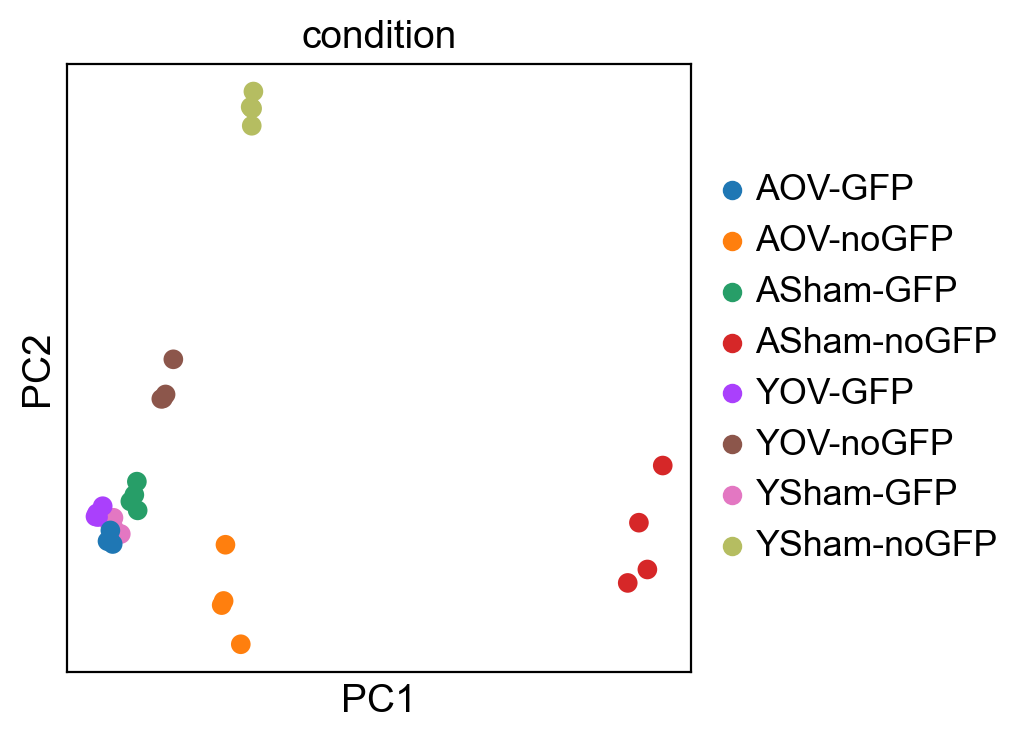

In [44]:
sc.tl.pca(dds)
sc.pl.pca(dds, color = 'condition', size = 200)

In [130]:
stat_res = DeseqStats(dds, contrast=('condition', 'YSham-GFP', 'ASham-GFP'))
stat_res.summary()


Running Wald tests...


Log2 fold change & Wald test p-value: condition YSham-GFP vs ASham-GFP
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
Xkr4             1.160966       -1.889785  1.842530 -1.025647  0.305058   
Gm1992           0.006968        0.826513  6.246123  0.132324  0.894728   
Gm19938          0.135903       -0.432629  2.747476 -0.157464  0.874879   
Rp1              0.130772        0.826513  6.249442  0.132254  0.894783   
Sox17           56.901798       -0.932835  0.284288 -3.281304  0.001033   
...                   ...             ...       ...       ...       ...   
Vamp7            6.305799        0.246439  0.616645  0.399646  0.689417   
Tmlhe            2.573298        0.790123  1.124094  0.702897  0.482120   
4933409K07Rik    0.052834        0.826513  6.247606  0.132293  0.894753   
CAAA01147332.1   0.861231        1.141927  1.084520  1.052933  0.292372   
AC149090.1       7.513033       -0.425506  0.660452 -0.644265  0.519404   

                    padj  
X

... done in 6.83 seconds.



In [131]:
de  = stat_res.results_df

In [132]:
de

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Xkr4,1.160966,-1.889785,1.842530,-1.025647,0.305058,NaN
Gm1992,0.006968,0.826513,6.246123,0.132324,0.894728,NaN
Gm19938,0.135903,-0.432629,2.747476,-0.157464,0.874879,NaN
Rp1,0.130772,0.826513,6.249442,0.132254,0.894783,NaN
Sox17,56.901798,-0.932835,0.284288,-3.281304,0.001033,0.025160
...,...,...,...,...,...,...
Vamp7,6.305799,0.246439,0.616645,0.399646,0.689417,NaN
Tmlhe,2.573298,0.790123,1.124094,0.702897,0.482120,NaN
4933409K07Rik,0.052834,0.826513,6.247606,0.132293,0.894753,NaN
CAAA01147332.1,0.861231,1.141927,1.084520,1.052933,0.292372,NaN


In [133]:
de.sort_values('stat', ascending = False)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Cmss1,134.891498,1.509228,0.164105,9.196710,3.690773e-20,1.797406e-16
Camk1d,62.115639,1.494975,0.184394,8.107501,5.167133e-16,8.387978e-13
Gphn,114.786199,1.383288,0.203618,6.793532,1.094207e-11,8.881311e-09
Rpl4,106.624931,0.918938,0.141030,6.515930,7.224043e-11,4.397636e-08
Sdc4,25.637322,2.756303,0.461768,5.969020,2.386822e-09,1.056711e-06
...,...,...,...,...,...,...
Lpl,128.577180,-1.436465,0.228287,-6.292358,3.126799e-10,1.691945e-07
Slc6a6,113.286415,-1.179137,0.175506,-6.718502,1.836023e-11,1.277347e-08
Rbp7,41.311469,-3.012149,0.425885,-7.072685,1.519644e-12,1.480133e-09
Serinc3,132.622985,-1.047730,0.134442,-7.793151,6.535856e-15,7.957404e-12


In [134]:
# Assuming 'res' is your DataFrame
de['Symbol'] = de.index
# Make 'Symbol' column uppercase
de['Symbol'] = de['Symbol'].str.upper()
de

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Symbol
Xkr4,1.160966,-1.889785,1.842530,-1.025647,0.305058,NaN,XKR4
Gm1992,0.006968,0.826513,6.246123,0.132324,0.894728,NaN,GM1992
Gm19938,0.135903,-0.432629,2.747476,-0.157464,0.874879,NaN,GM19938
Rp1,0.130772,0.826513,6.249442,0.132254,0.894783,NaN,RP1
Sox17,56.901798,-0.932835,0.284288,-3.281304,0.001033,0.025160,SOX17
...,...,...,...,...,...,...,...
Vamp7,6.305799,0.246439,0.616645,0.399646,0.689417,NaN,VAMP7
Tmlhe,2.573298,0.790123,1.124094,0.702897,0.482120,NaN,TMLHE
4933409K07Rik,0.052834,0.826513,6.247606,0.132293,0.894753,NaN,4933409K07RIK
CAAA01147332.1,0.861231,1.141927,1.084520,1.052933,0.292372,NaN,CAAA01147332.1


In [50]:
# Assuming 'de' is your DataFrame
de_sorted = de.sort_values('stat', ascending=False)

# Save the DataFrame with gene names as the index
de_sorted.to_csv('ASham Endothelial cellsnew.csv')


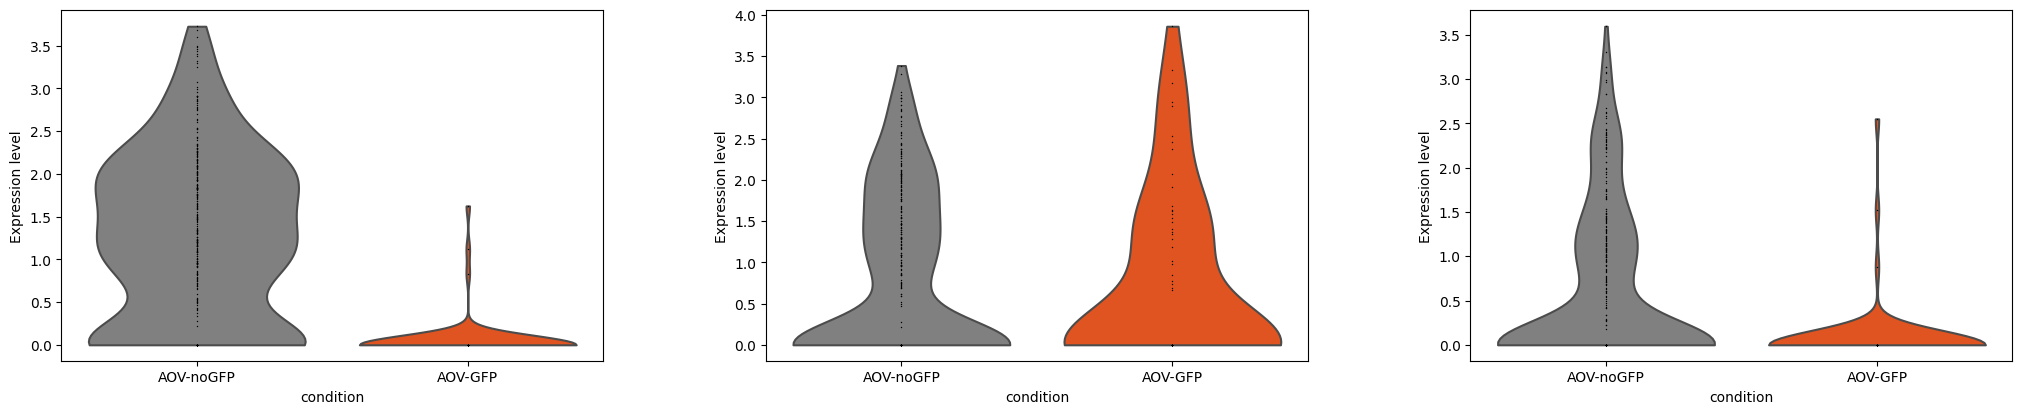

In [25]:
sc.pl.violin(cell_subset, ['Col3a1', 'Pdgfd', 'Col1a2'], groupby='condition',
             order=['AOV-noGFP', 'AOV-GFP'], jitter=False, figsize=(8,8),
             palette={'AOV-GFP': '#FF4500', 'AOV-noGFP': 'gray'},
             ylabel='Expression level', yticklabels='on_data',
             save='FAPMACRESMAC2fapmac2.png')

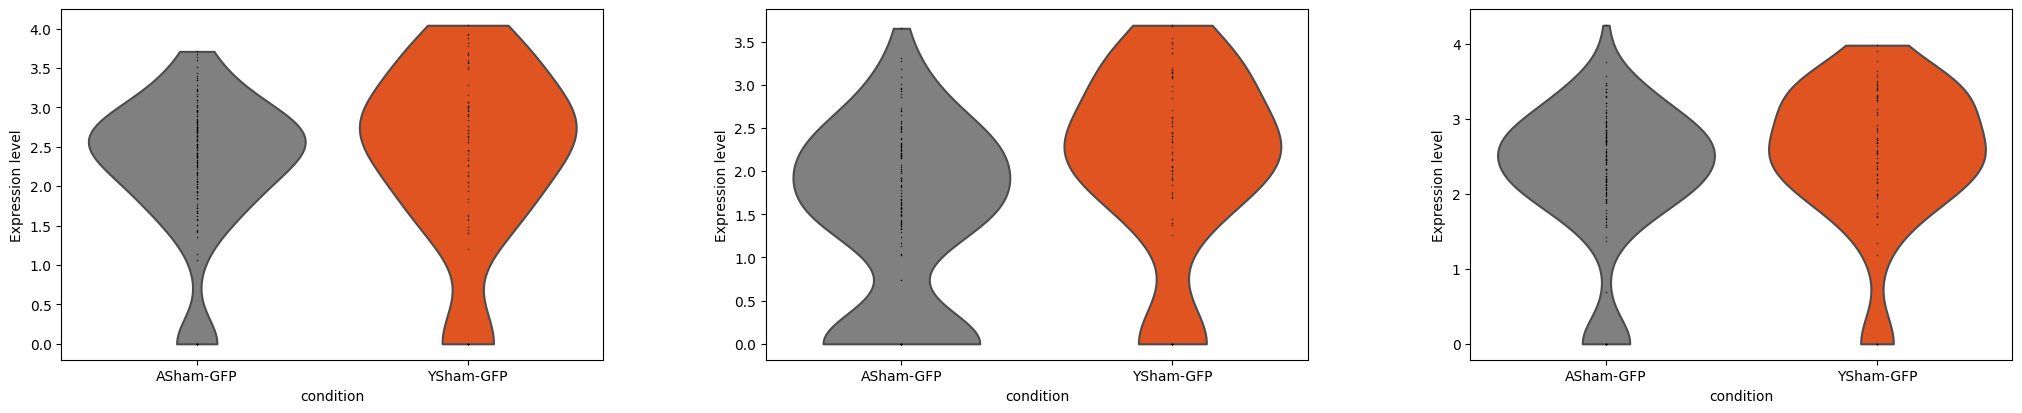

In [41]:
sc.pl.violin(cell_subset, ['Rplp0', 'Rpl12', 'Rpl26'], groupby='condition',
             order=['ASham-GFP', 'YSham-GFP'], jitter=False, figsize=(8,8),
             palette={'YSham-GFP': '#FF4500', 'ASham-GFP': 'gray'},
             ylabel='Expression level', yticklabels='on_data',
             save='FAPMACRESMAC2fapmac2.png')

In [ ]:
Rapgef1, Ralgapa1

In [148]:
res = stat_res.results_df
res
# Assuming 'res' is your DataFrame
res['Symbol'] = res.index

# Print the DataFrame with gene symbols
print(res)
res
res = res[res.baseMean >= 10]
res
sigs = res[(res.padj < 0.05) & (abs(res.log2FoldChange) > 0.5)]
sigs


                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
Xkr4             1.160966       -1.889785  1.842530 -1.025647  0.305058   
Gm1992           0.006968        0.826513  6.246123  0.132324  0.894728   
Gm19938          0.135903       -0.432629  2.747476 -0.157464  0.874879   
Rp1              0.130772        0.826513  6.249442  0.132254  0.894783   
Sox17           56.901798       -0.932835  0.284288 -3.281304  0.001033   
...                   ...             ...       ...       ...       ...   
Vamp7            6.305799        0.246439  0.616645  0.399646  0.689417   
Tmlhe            2.573298        0.790123  1.124094  0.702897  0.482120   
4933409K07Rik    0.052834        0.826513  6.247606  0.132293  0.894753   
CAAA01147332.1   0.861231        1.141927  1.084520  1.052933  0.292372   
AC149090.1       7.513033       -0.425506  0.660452 -0.644265  0.519404   

                    padj          Symbol  
Xkr4                 NaN            Xkr4  
Gm1992       

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Symbol
Sox17,56.901798,-0.932835,0.284288,-3.281304,1.033283e-03,0.025160,Sox17
Rpl31,72.563744,0.634542,0.185310,3.424217,6.165735e-04,0.018650,Rpl31
Col3a1,23.457159,2.504635,0.530519,4.721107,2.345649e-06,0.000272,Col3a1
Nop58,53.896873,0.632549,0.195398,3.237230,1.206960e-03,0.028209,Nop58
Klf7,85.136622,-1.022893,0.179714,-5.691772,1.257280e-08,0.000004,Klf7
...,...,...,...,...,...,...,...
Rpl10,257.582319,0.766209,0.151002,5.074159,3.892132e-07,0.000059,Rpl10
Rps4x,421.487419,0.601253,0.180670,3.327905,8.750180e-04,0.023064,Rps4x
Rpl36a,143.801656,0.684513,0.227718,3.005967,2.647377e-03,0.047748,Rpl36a
Tsc22d3,25.697350,-1.491193,0.356867,-4.178564,2.933552e-05,0.001855,Tsc22d3


In [149]:
import numpy as np
import seaborn as sns
dds.layers['normed_counts']
dds.layers['log1p'] = np.log1p(dds.layers['normed_counts'])
dds.layers['log1p']
sigs
dds_sigs = dds[:, sigs.index]
dds_sigs
grapher = pd.DataFrame(dds_sigs.layers['log1p'].T,
                       index=dds_sigs.var_names, columns=dds_sigs.obs_names)

<Figure size 1000x800 with 0 Axes>

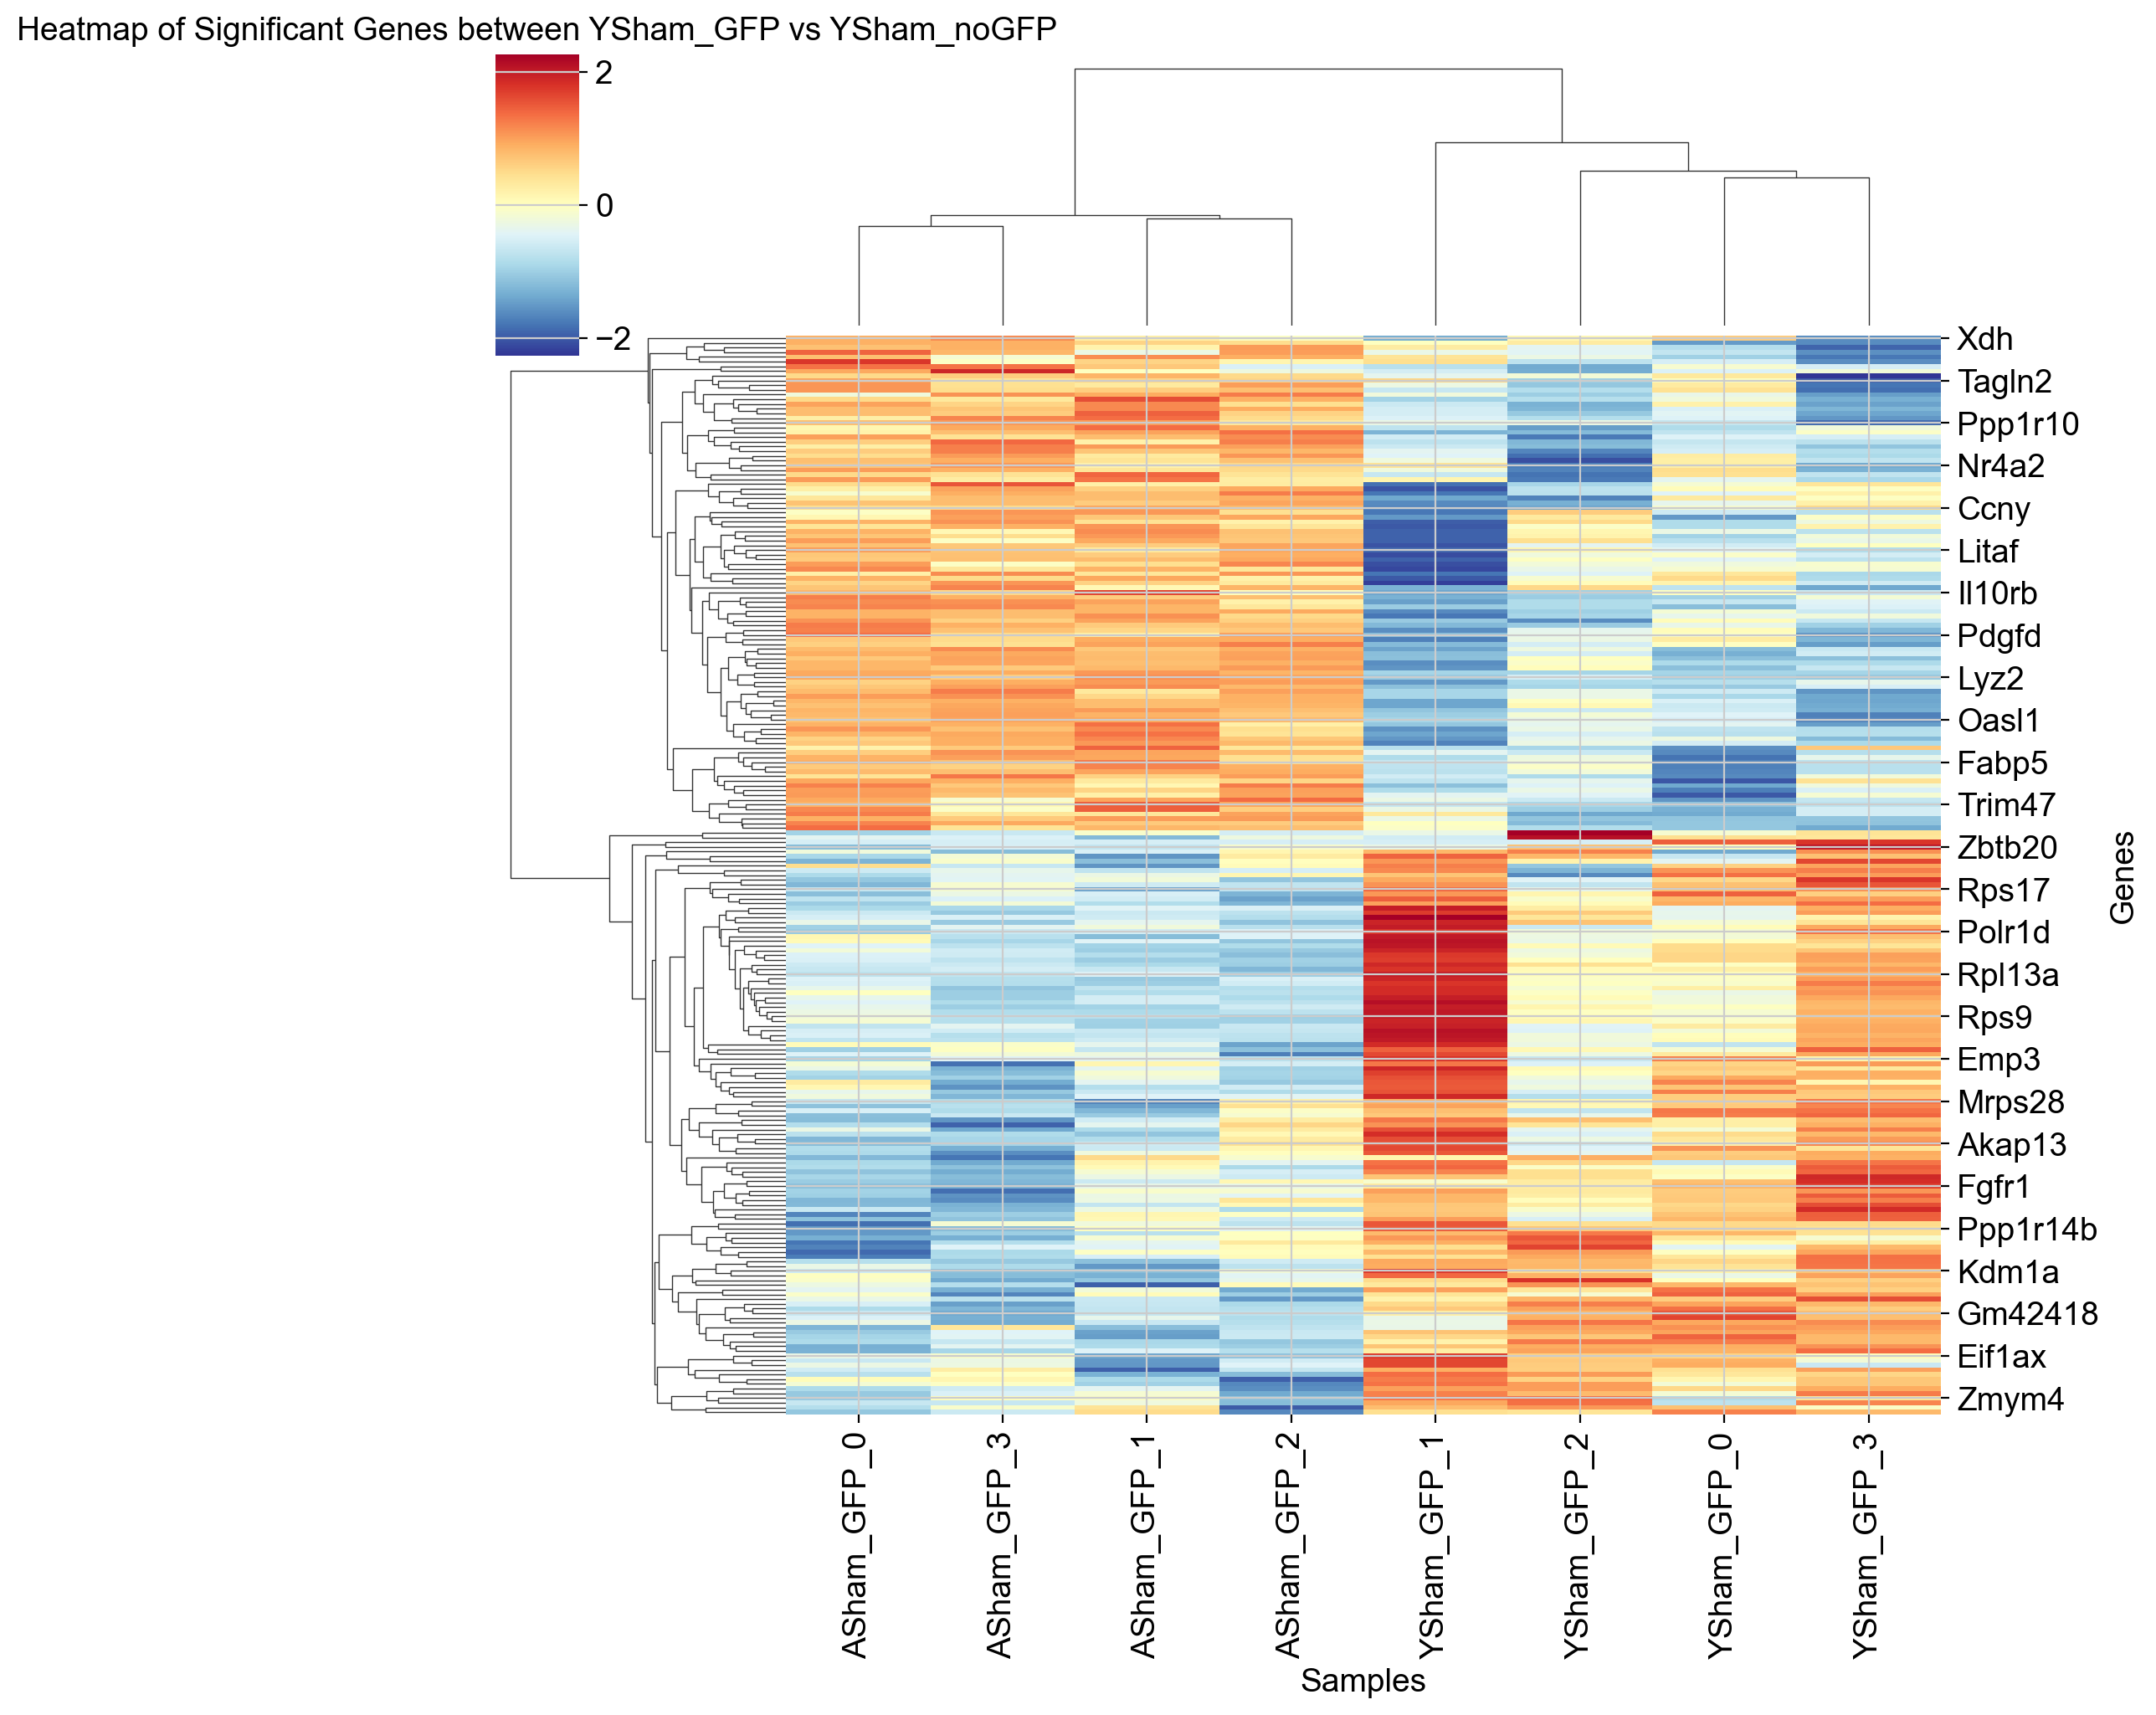

In [150]:
import matplotlib.pyplot as plt

# Confirm and select columns of interest
conditions_of_interest = ['YSham_GFP_0', 'YSham_GFP_1', 'YSham_GFP_2', 'YSham_GFP_3',
                          'ASham_GFP_0', 'ASham_GFP_1', 'ASham_GFP_2', 'ASham_GFP_3']

# Subset grapher DataFrame for significant genes and conditions of interest
grapher_subset = grapher.loc[sigs.index.intersection(grapher.index), conditions_of_interest]

# Create and display the clustermap
plt.figure(figsize=(10, 8))  # Adjust figure size as needed
clustermap = sns.clustermap(grapher_subset, z_score=0, cmap='RdYlBu_r')
clustermap.ax_heatmap.set_xlabel('Samples')
clustermap.ax_heatmap.set_ylabel('Genes')
plt.title('Heatmap of Significant Genes between YSham_GFP vs YSham_noGFP')
plt.savefig('clustermap_YSham.png')  # Save the clustermap as an image file
plt.show()


<Figure size 1000x800 with 0 Axes>

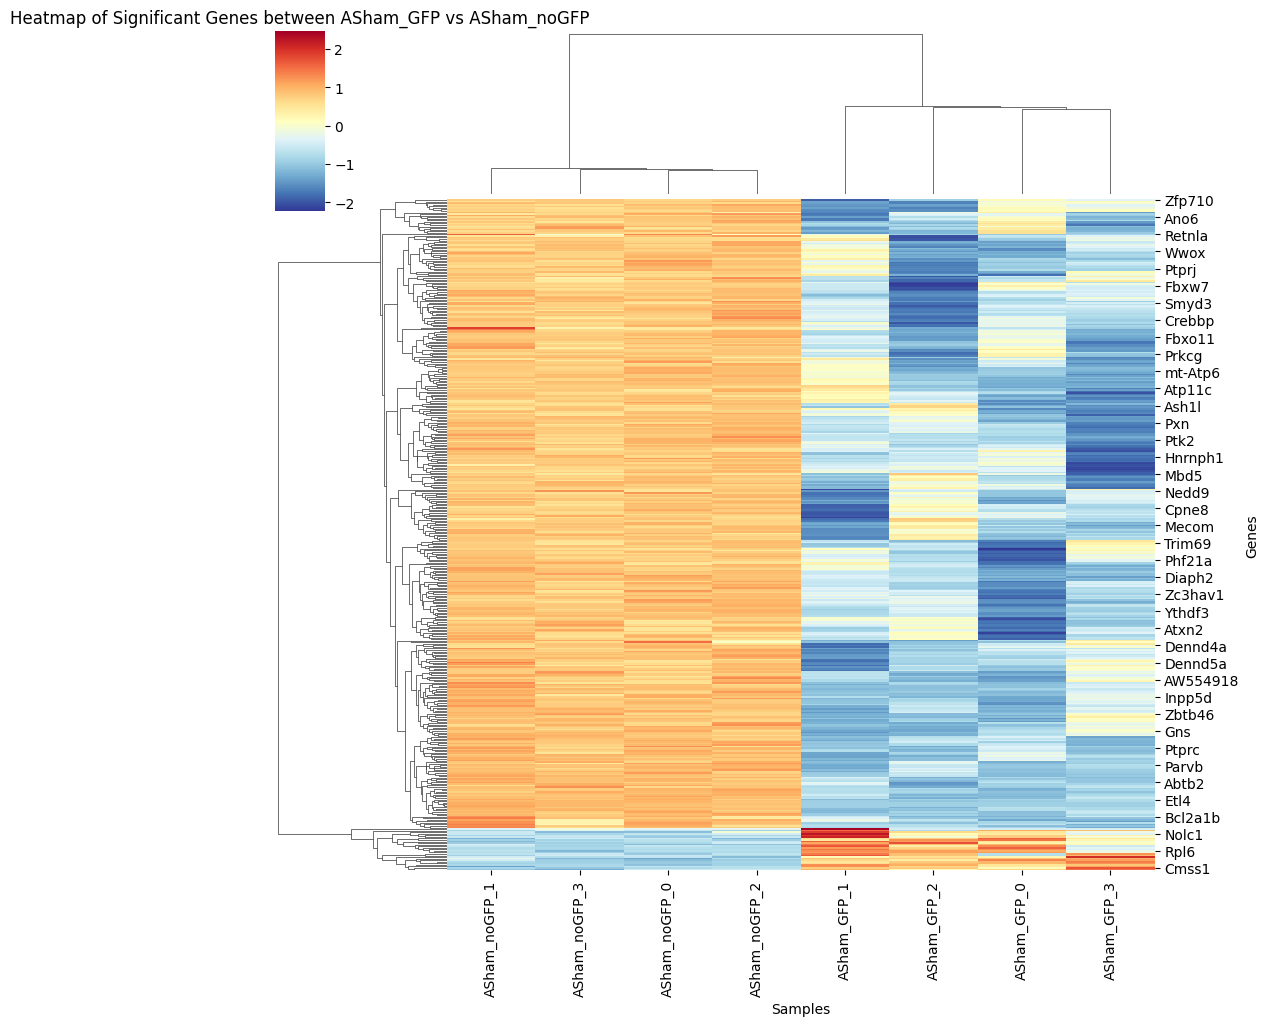

In [26]:
import matplotlib.pyplot as plt

# Confirm and select columns of interest
conditions_of_interest = ['ASham_GFP_0', 'ASham_GFP_1', 'ASham_GFP_2', 'ASham_GFP_3',
                          'ASham_noGFP_0', 'ASham_noGFP_1', 'ASham_noGFP_2', 'ASham_noGFP_3']

# Subset grapher DataFrame for significant genes and conditions of interest
grapher_subset = grapher.loc[sigs.index.intersection(grapher.index), conditions_of_interest]

# Create and display the clustermap
plt.figure(figsize=(10, 8))  # Adjust figure size as needed
clustermap = sns.clustermap(grapher_subset, z_score=0, cmap='RdYlBu_r')
clustermap.ax_heatmap.set_xlabel('Samples')
clustermap.ax_heatmap.set_ylabel('Genes')
plt.title('Heatmap of Significant Genes between ASham_GFP vs ASham_noGFP')
plt.savefig('clustermap_YSham.png')  # Save the clustermap as an image file
plt.show()


<Figure size 1000x800 with 0 Axes>

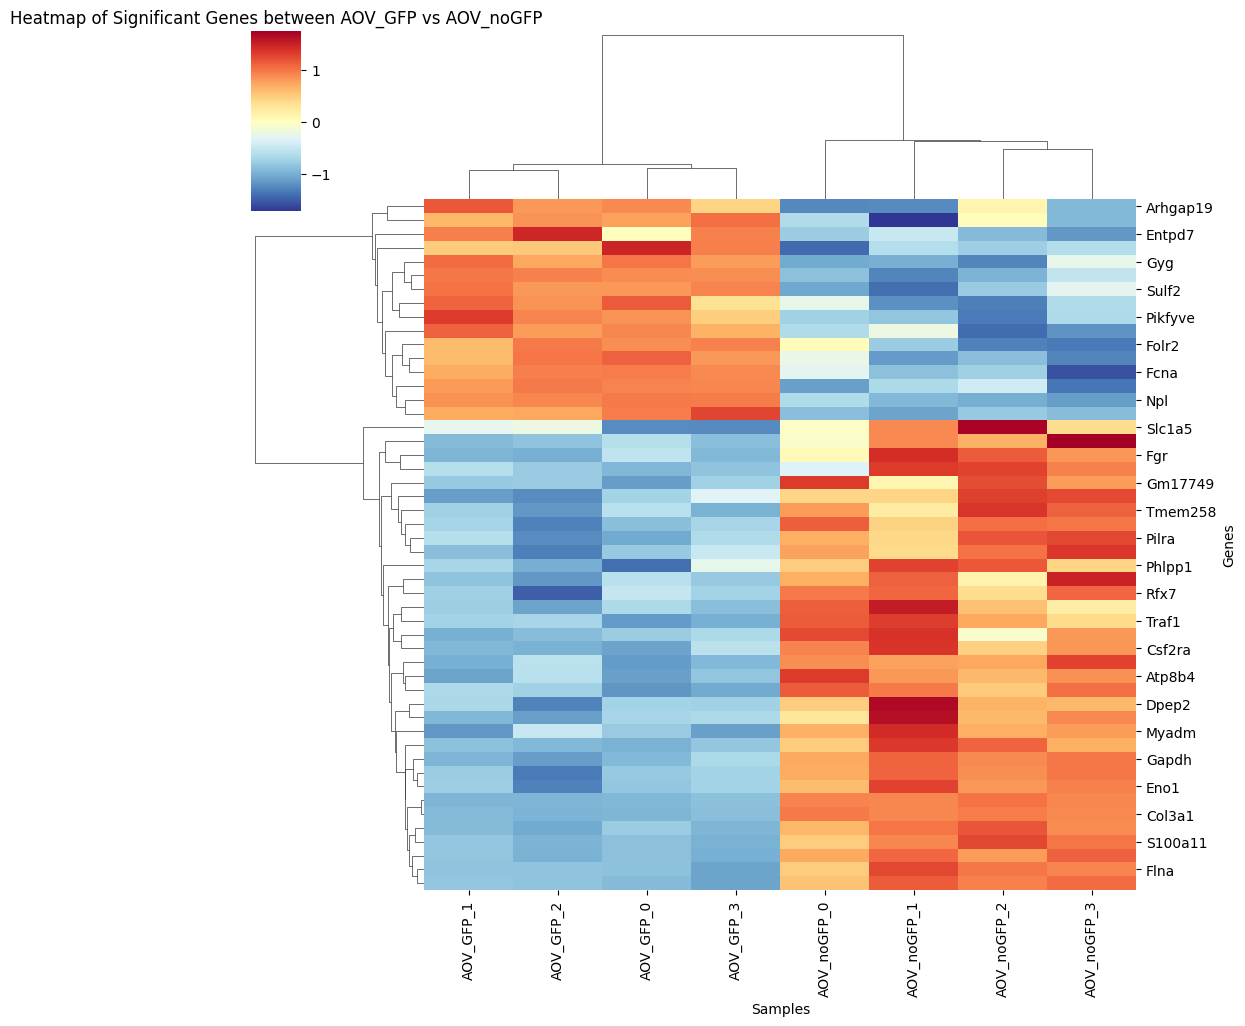

In [57]:
import matplotlib.pyplot as plt

# Confirm and select columns of interest
conditions_of_interest = ['AOV_GFP_0', 'AOV_GFP_1', 'AOV_GFP_2', 'AOV_GFP_3',
                          'AOV_noGFP_0', 'AOV_noGFP_1', 'AOV_noGFP_2', 'AOV_noGFP_3']

# Subset grapher DataFrame for significant genes and conditions of interest
grapher_subset = grapher.loc[sigs.index.intersection(grapher.index), conditions_of_interest]

# Create and display the clustermap
plt.figure(figsize=(10, 8))  # Adjust figure size as needed
clustermap = sns.clustermap(grapher_subset, z_score=0, cmap='RdYlBu_r')
clustermap.ax_heatmap.set_xlabel('Samples')
clustermap.ax_heatmap.set_ylabel('Genes')
plt.title('Heatmap of Significant Genes between AOV_GFP vs AOV_noGFP')
plt.savefig('clustermap_AOV.png')  # Save the clustermap as an image file
plt.show()


<Figure size 1000x800 with 0 Axes>

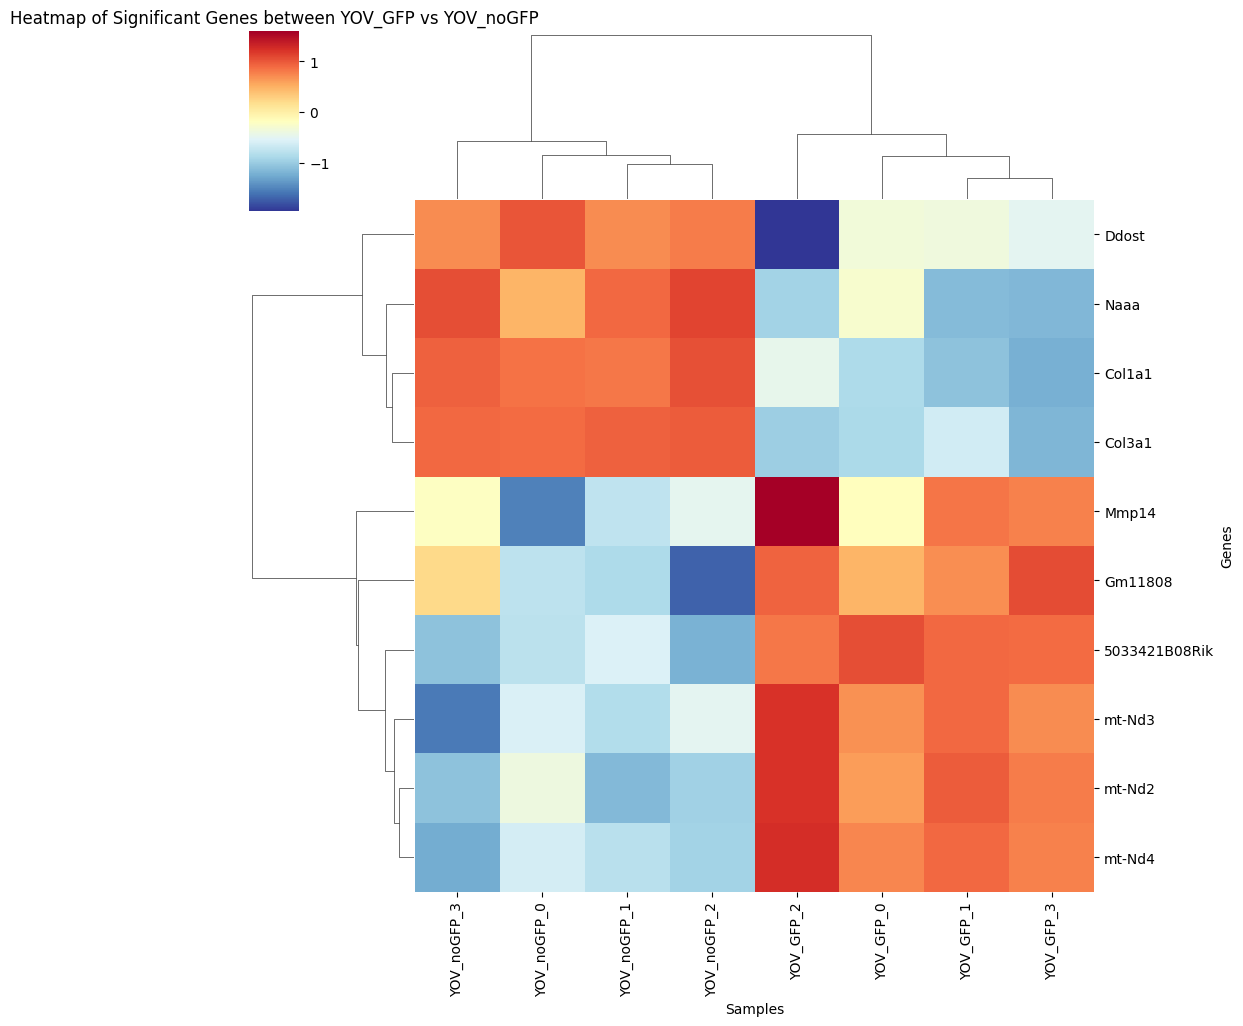

In [23]:
import matplotlib.pyplot as plt

# Confirm and select columns of interest
conditions_of_interest = ['YOV_GFP_0', 'YOV_GFP_1', 'YOV_GFP_2', 'YOV_GFP_3',
                          'YOV_noGFP_0', 'YOV_noGFP_1', 'YOV_noGFP_2', 'YOV_noGFP_3']

# Subset grapher DataFrame for significant genes and conditions of interest
grapher_subset = grapher.loc[sigs.index.intersection(grapher.index), conditions_of_interest]

# Create and display the clustermap
plt.figure(figsize=(10, 8))  # Adjust figure size as needed
clustermap = sns.clustermap(grapher_subset, z_score=0, cmap='RdYlBu_r')
clustermap.ax_heatmap.set_xlabel('Samples')
clustermap.ax_heatmap.set_ylabel('Genes')
plt.title('Heatmap of Significant Genes between YOV_GFP vs YOV_noGFP')
plt.savefig('clustermap_YOV.png')  # Save the clustermap as an image file
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Confirm and select columns of interest
conditions_of_interest = ['YSham_GFP_0', 'YSham_GFP_1', 'YSham_GFP_2', 'YSham_GFP_3',
                          'YSham_noGFP_0', 'YSham_noGFP_1', 'YSham_noGFP_2', 'YSham_noGFP_3']

# Subset grapher DataFrame for significant genes and conditions of interest
grapher_subset = grapher.loc[sigs.index.intersection(grapher.index), conditions_of_interest]

# Create and display the clustermap
plt.figure(figsize=(10, 8))  # Adjust figure size as needed
clustermap = sns.clustermap(grapher_subset, z_score=0, cmap='RdYlBu_r')
clustermap.ax_heatmap.set_xlabel('Samples')
clustermap.ax_heatmap.set_ylabel('Genes')
plt.title('Heatmap of Significant Genes between YSham_GFP vs YSham_noGFP')
plt.savefig('clustermap_YSham.png')  # Save the clustermap as an image file
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Confirm and select columns of interest
conditions_of_interest = ['AOV_GFP_0', 'AOV_GFP_1', 'AOV_GFP_2', 'AOV_GFP_3',
                          'AOV_noGFP_0', 'AOV_noGFP_1', 'AOV_noGFP_2', 'AOV_noGFP_3']

# Subset grapher DataFrame for significant genes and conditions of interest
grapher_subset = grapher.loc[sigs.index.intersection(grapher.index), conditions_of_interest]

# Create and display the clustermap
plt.figure(figsize=(10, 8))  # Adjust figure size as needed
clustermap = sns.clustermap(grapher_subset, z_score=0, cmap='RdYlBu_r')
clustermap.ax_heatmap.set_xlabel('Samples')
clustermap.ax_heatmap.set_ylabel('Genes')
plt.title('Heatmap of Significant Genes between AOV_GFP vs AOV_noGFP')
plt.savefig('clustermap_AOV.png')  # Save the clustermap as an image file
plt.show()
